# 之前的代码

图表已保存至: output_image\maxTE_bar_chart.png


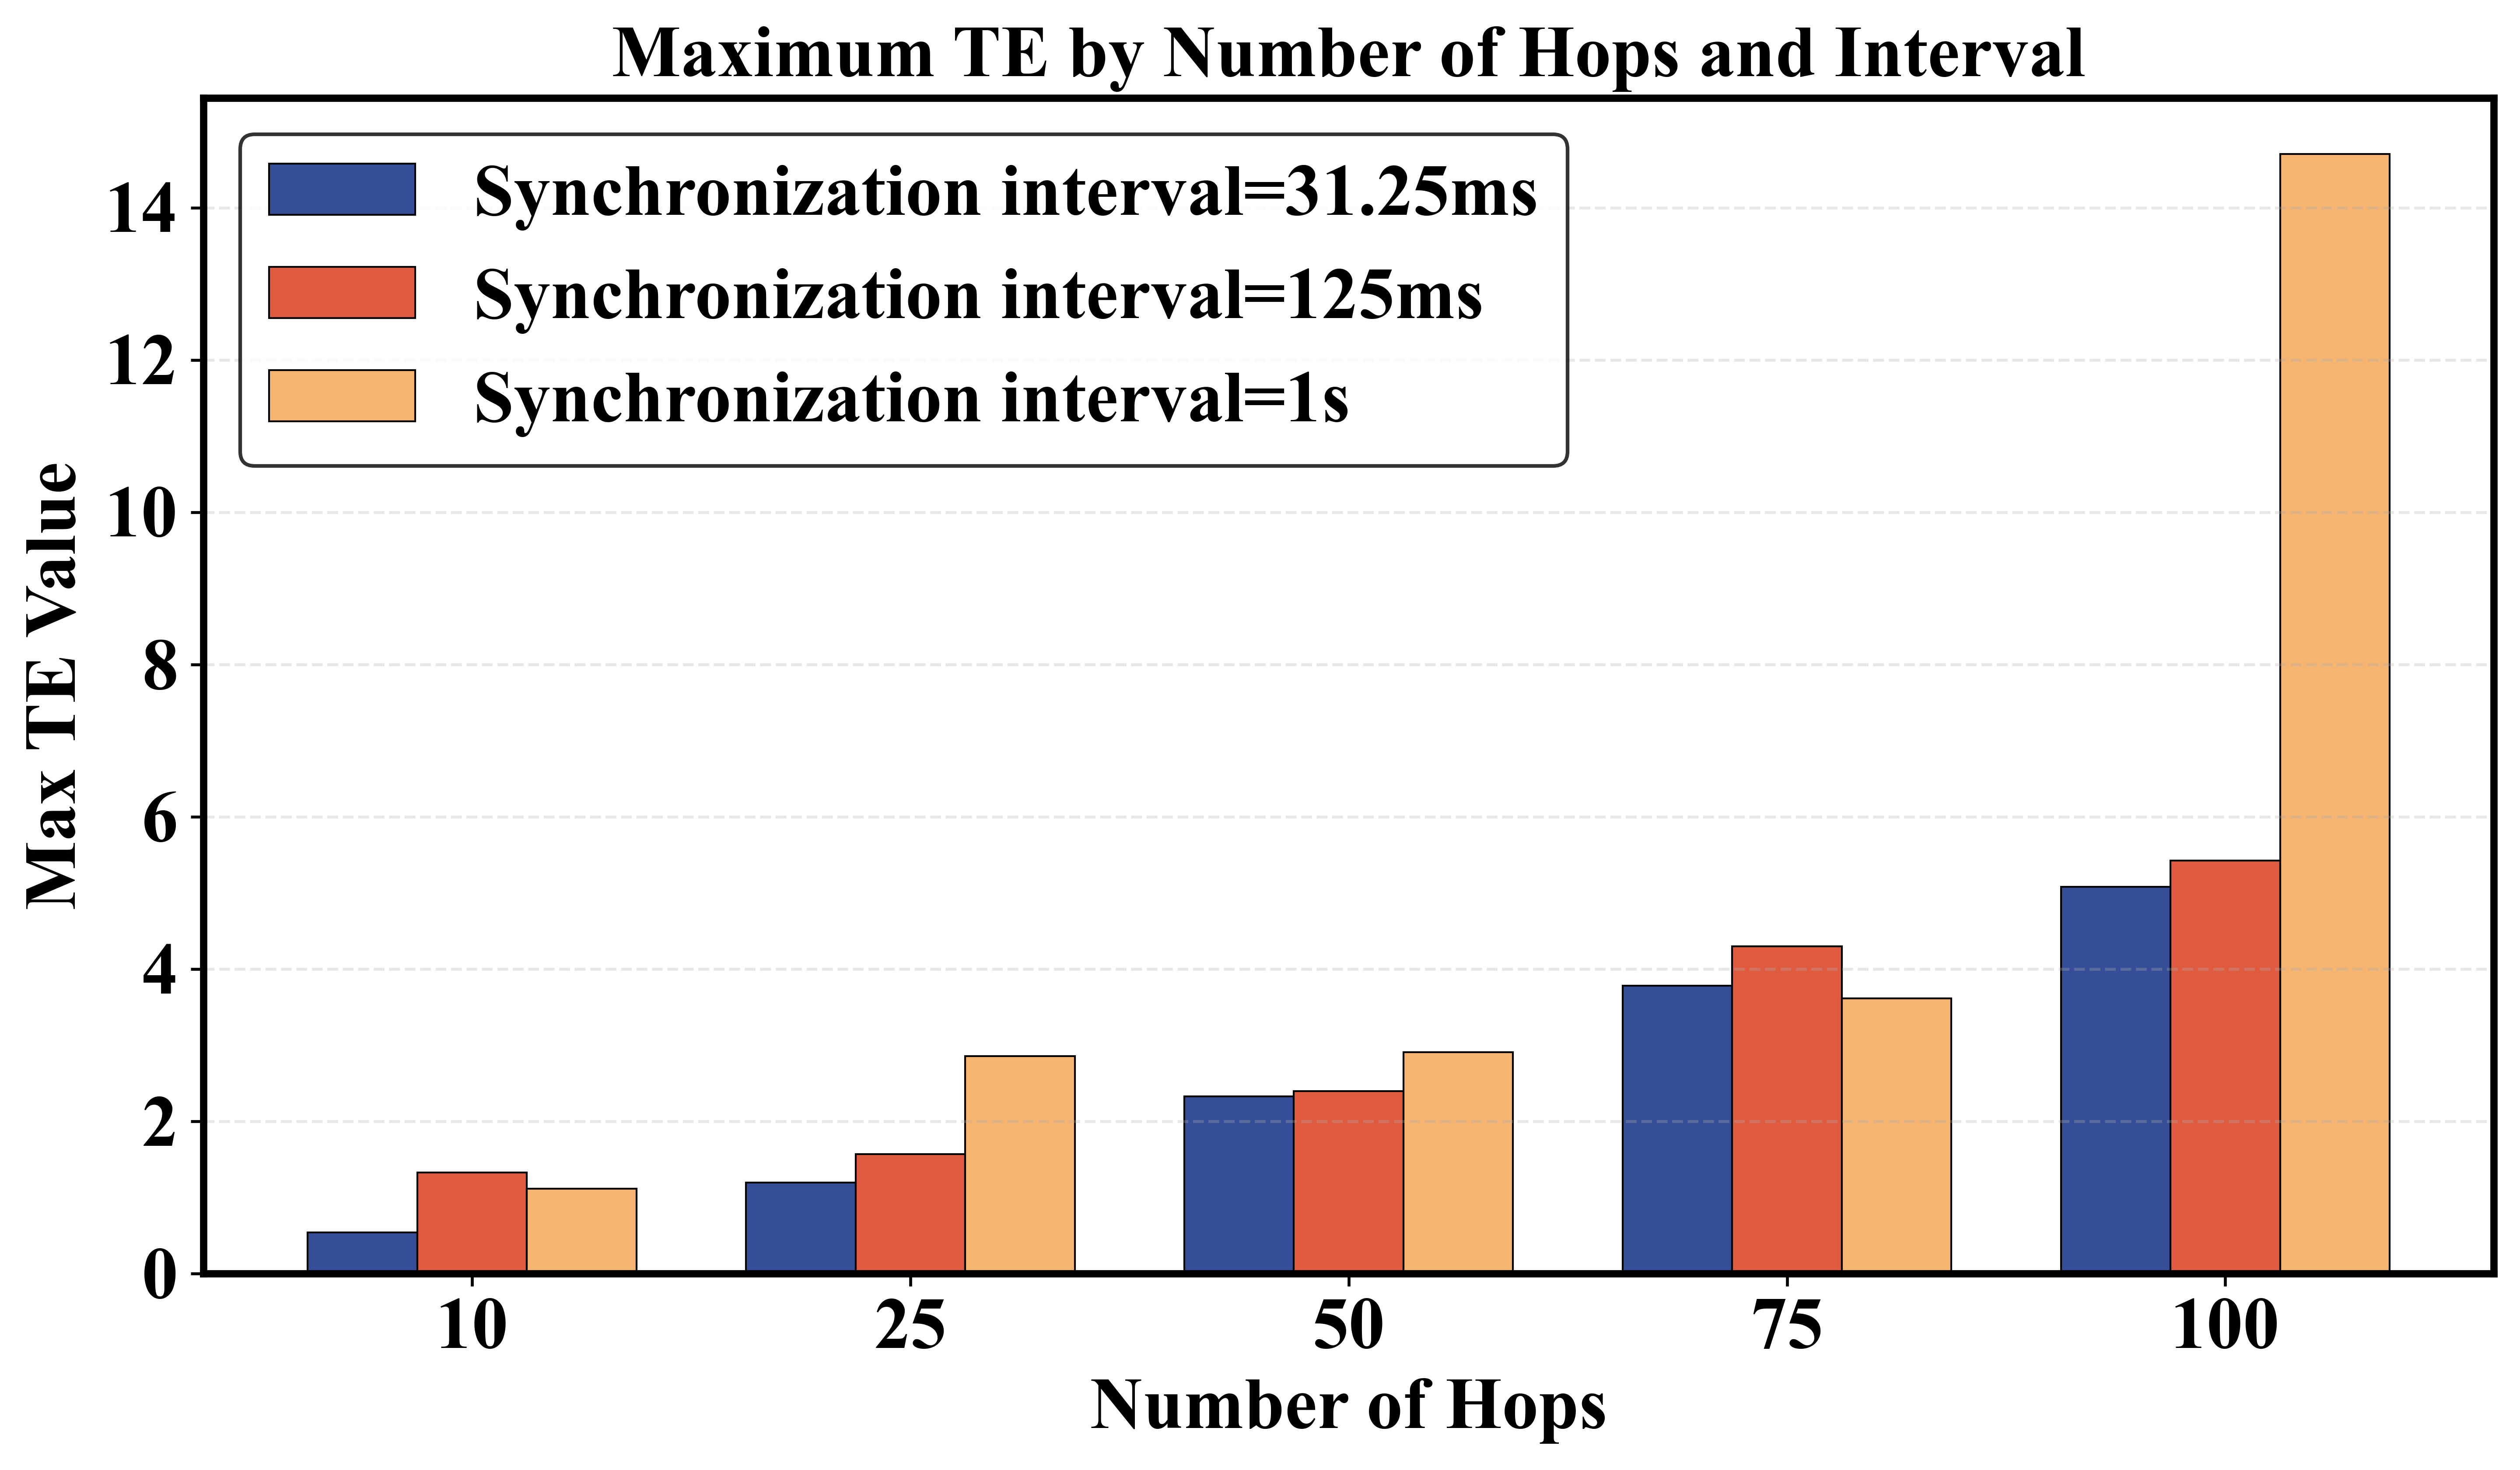

In [10]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/4/9 21:54
*  @Project :   pj_gptp_simulation
*  @Description :   Description
*  @FileName:   tiaoxingtu_20250409V1.py
**************************************
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# 设置CSV文件路径（请修改为您的实际路径）
csv_path = r"input_data\maxTE_old.csv"  # 可以是相对路径或绝对路径

# 检查文件是否存在
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV文件未找到，请检查路径: {csv_path}")

# 从CSV文件读取数据
try:
    df = pd.read_csv(csv_path)
except Exception as e:
    raise ValueError(f"读取CSV文件失败: {str(e)}")

# 检查数据格式是否正确
required_columns = ['hops', 'Synchronization interval=31.25ms', 'Synchronization interval=125ms', 'Synchronization interval=1s']
if not all(col in df.columns for col in required_columns):
    raise ValueError("CSV文件列名不符合要求，请确保包含: hops, interval=31.25ms, interval=125ms, interval=1s")

# 使用您提供的配色方案 [053,078,151], [223,091,063], [245,180,111]
# 将RGB转换为十六进制颜色码
colors = ['#354e97', '#df5b3f', '#f5b46f']  # 对应RGB(53,78,151), (223,91,63), (245,180,111)

# 设置全局字体为Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'  # 全局字体设置
plt.rcParams['mathtext.fontset'] = 'custom'  # 如果需要数学公式也使用Times New Roman
plt.rcParams['mathtext.rm'] = 'Times New Roman'  # 数学公式常规字体
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'  # 数学公式斜体
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'  # 数学公式粗体

# 创建图表
plt.figure(figsize=(10, 6), dpi=600)

# 设置学术风格
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# 条形图参数
bar_width = 0.25
x = np.arange(len(df['hops']))

# 绘制条形图
for i, col in enumerate(df.columns[1:]):  # 跳过第一列'hops'
    plt.bar(x + i*bar_width, df[col], width=bar_width,
            color=colors[i], edgecolor='black', linewidth=0.5,
            label=col)

# 添加图表元素
plt.xlabel('Number of Hops', fontsize=20, fontweight='bold')
plt.ylabel('Max TE Value', fontsize=20, fontweight='bold')
plt.title('Maximum TE by Number of Hops and Interval', fontsize=20, fontweight='bold')
plt.xticks(x + bar_width, df['hops'], fontsize=20)
plt.yticks(fontsize=20)

# 添加图例和网格
plt.legend(fontsize=20, frameon=True, shadow=False, edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# 调整布局并显示
plt.tight_layout()

# 保存图表（取消注释以保存）
output_dir = "output_image"
os.makedirs(output_dir, exist_ok=True)  # 创建输出目录
output_path = os.path.join(output_dir, r"maxTE_bar_chart.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"图表已保存至: {output_path}")

plt.show()



# 基于论文改进的 代码和画图

https://poe.com/s/A9EiqxQ2QrXNPAPEUVtb

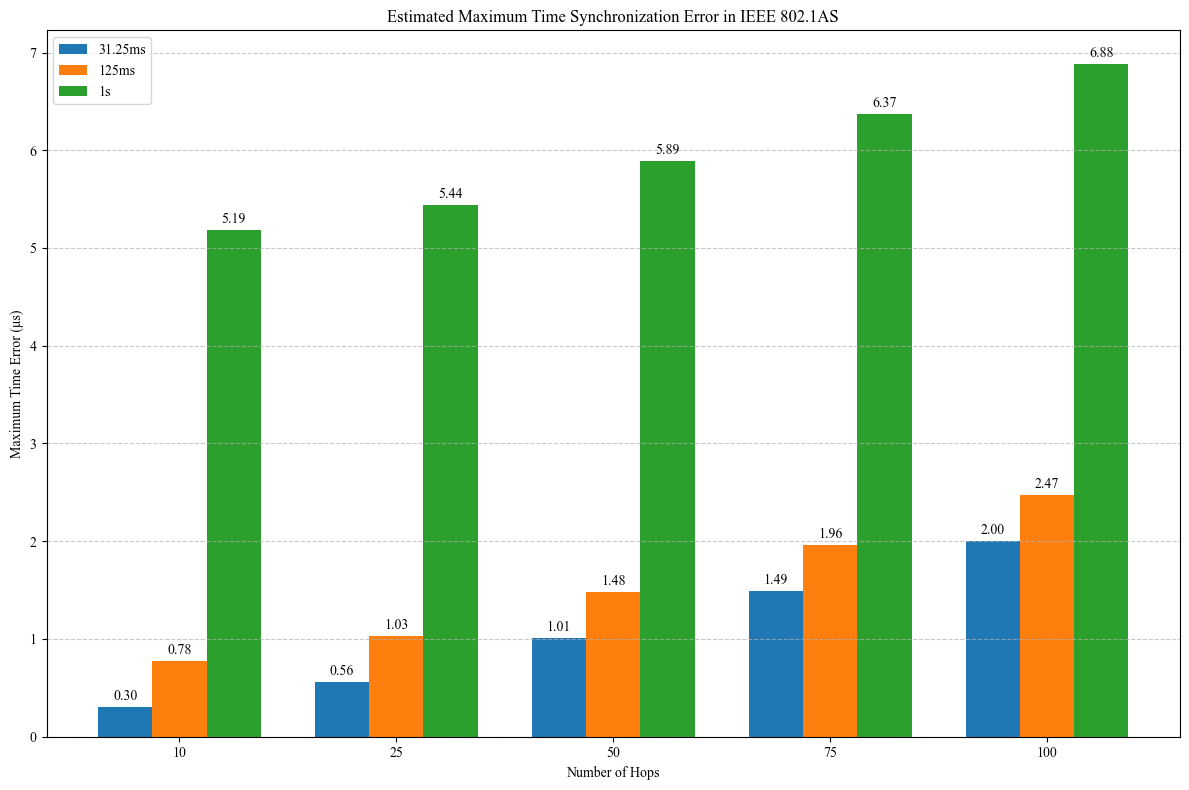

Estimated Maximum Time Errors (μs):
Hops	31.25ms	125ms	1s
10	0.30	0.78	5.19
25	0.56	1.03	5.44
50	1.01	1.48	5.89
75	1.49	1.96	6.37
100	2.00	2.47	6.88


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters based on the paper
sync_intervals = [0.03125, 0.125, 1.0]  # in seconds: 31.25ms, 125ms, 1s
hops_list = [10, 25, 50, 75, 100]
max_drift_rate = 10e-6  # 10 ppm (parts per million)
phy_jitter = 8e-9  # 8 ns (nanoseconds)
clock_granularity = 8e-9  # 8 ns
residence_time = 1e-3  # 1 ms (milliseconds)
neighbor_rate_ratio_error = 0.1e-6  # 0.1 ppm

# Function to calculate theoretical worst-case error based on paper's formulas
def calculate_theoretical_error(sync_interval, num_hops):
    # Error due to clock drift (equation 11)
    drift_error = 2 * max_drift_rate * sync_interval  # (ρi - ρGM) with worst case
    
    # Calculate max neighbor rate ratio (equation 19)
    max_nr = (1 + max_drift_rate) / (1 - max_drift_rate)
    
    # Error in timestamping
    delta_t = phy_jitter + clock_granularity
    
    # Error in propagation delay (equation 20)
    delta_D = (1 + max_nr) * delta_t + 0.5 * residence_time * neighbor_rate_ratio_error
    
    # Error in rate ratio (equation 21)
    delta_r = max_nr * neighbor_rate_ratio_error * (num_hops - 2) if num_hops > 2 else 0
    
    # Error in correction field (equation 23)
    delta_C = (delta_D + residence_time * delta_r + 2 * max_nr * delta_t) * (num_hops - 1)
    
    # Total error (equation 24)
    total_error = drift_error + delta_C
    
    return total_error

# Calculate theoretical errors for each combination of sync interval and hops
theoretical_errors = np.zeros((len(sync_intervals), len(hops_list)))
for i, interval in enumerate(sync_intervals):
    for j, hops in enumerate(hops_list):
        theoretical_errors[i, j] = calculate_theoretical_error(interval, hops)

# Apply scaling factor based on paper's simulation results
# The paper reported ~2μs for 100 hops at 31.25ms, compared to theoretical ~6.925μs
theoretical_100_hops_31ms = calculate_theoretical_error(0.03125, 100)
observed_100_hops_31ms = 2e-6  # 2 μs reported from simulations
scaling_factor = observed_100_hops_31ms / theoretical_100_hops_31ms

# Apply scaling to all theoretical results to estimate actual expected errors
estimated_errors = theoretical_errors * scaling_factor

# Convert to microseconds for plotting
estimated_errors_us = estimated_errors * 1e6

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(hops_list))
width = 0.25

# Create bars for each synchronization interval
rects1 = ax.bar(x - width, estimated_errors_us[0], width, label='31.25ms')
rects2 = ax.bar(x, estimated_errors_us[1], width, label='125ms')
rects3 = ax.bar(x + width, estimated_errors_us[2], width, label='1s')

# Add labels and title
ax.set_ylabel('Maximum Time Error (μs)')
ax.set_xlabel('Number of Hops')
ax.set_title('Estimated Maximum Time Synchronization Error in IEEE 802.1AS')
ax.set_xticks(x)
ax.set_xticklabels(hops_list)
ax.legend()

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('ieee_802_1as_time_error.png')
plt.show()

# Print the values in tabular format
print("Estimated Maximum Time Errors (μs):")
print("Hops\t31.25ms\t125ms\t1s")
for j, hops in enumerate(hops_list):
    print(f"{hops}\t{estimated_errors_us[0, j]:.2f}\t{estimated_errors_us[1, j]:.2f}\t{estimated_errors_us[2, j]:.2f}")

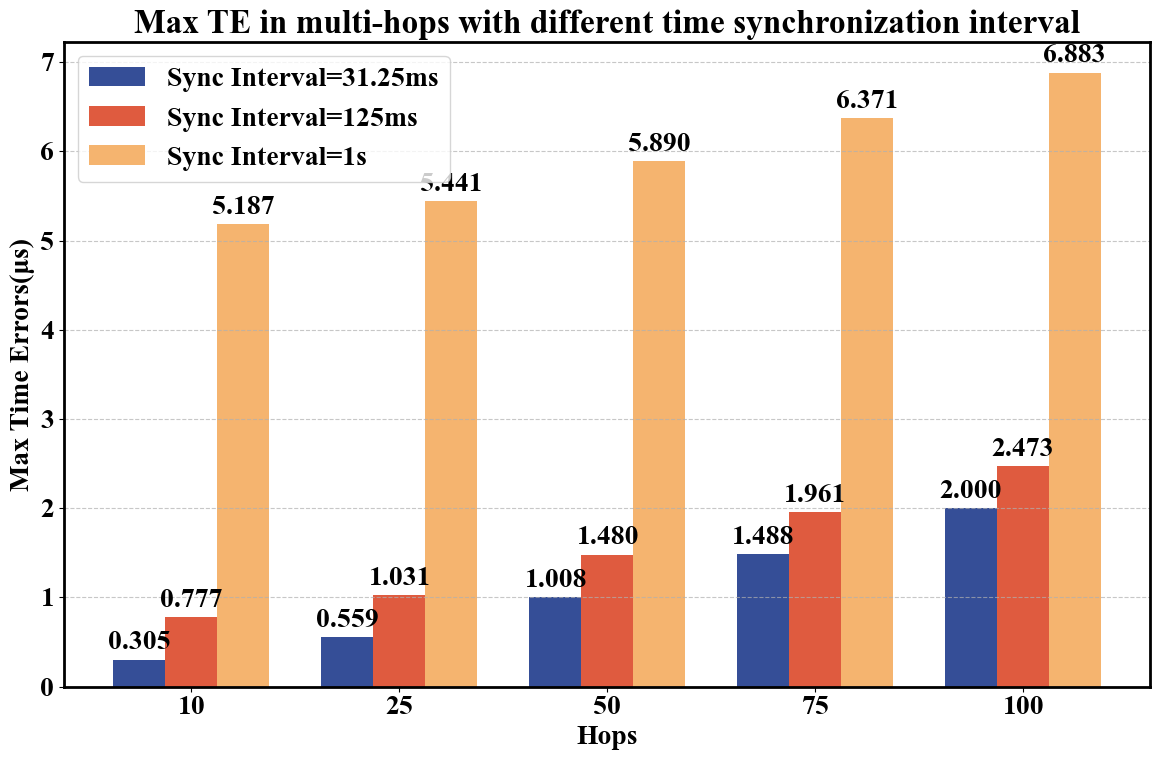

Mas TE(μs):
Hops 	31.25ms	125ms	1s
10	0.305	0.777	5.187
25	0.559	1.031	5.441
50	1.008	1.480	5.890
75	1.488	1.961	6.371
100	2.000	2.473	6.883


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置全局字体为Times New Roman，字号20，加粗
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 20,
    'font.weight': 'bold'
})

# 定义配色方案（RGB值除以255转换为0-1范围）
colors = [
    [x/255 for x in [53, 78, 151]],   # 蓝色
    [x/255 for x in [223, 91, 63]],   # 红色
    [x/255 for x in [245, 180, 111]]  # 橙色
]

# 根据论文设置的参数
sync_intervals = [0.03125, 0.125, 1.0]  # 同步间隔(秒): 31.25毫秒, 125毫秒, 1秒
hops_list = [10, 25, 50, 75, 100]       # 跳数列表
max_drift_rate = 10e-6                   # 最大漂移率: 10 ppm (百万分之一)
phy_jitter = 8e-9                        # 物理层抖动: 8纳秒
clock_granularity = 8e-9                 # 时钟粒度: 8纳秒
residence_time = 1e-3                    # 驻留时间: 1毫秒
neighbor_rate_ratio_error = 0.1e-6       # 邻居速率比误差: 0.1 ppm

def calculate_theoretical_error(sync_interval, num_hops):
    """计算理论最坏情况误差(基于论文公式)
    
    参数:
        sync_interval: 同步间隔(秒)
        num_hops: 跳数
        
    返回:
        总误差(秒)
    """
    # 时钟漂移导致的误差(公式11)
    drift_error = 2 * max_drift_rate * sync_interval  # (ρi - ρGM) 最坏情况
    
    # 计算最大邻居速率比(公式19)
    max_nr = (1 + max_drift_rate) / (1 - max_drift_rate)
    
    # 时间戳误差
    delta_t = phy_jitter + clock_granularity
    
    # 传播延迟误差(公式20)
    delta_D = (1 + max_nr) * delta_t + 0.5 * residence_time * neighbor_rate_ratio_error
    
    # 速率比误差(公式21)
    delta_r = max_nr * neighbor_rate_ratio_error * (num_hops - 2) if num_hops > 2 else 0
    
    # 校正字段误差(公式23)
    delta_C = (delta_D + residence_time * delta_r + 2 * max_nr * delta_t) * (num_hops - 1)
    
    # 总误差(公式24)
    total_error = drift_error + delta_C
    
    return total_error

# 为每个同步间隔和跳数组合计算理论误差
theoretical_errors = np.zeros((len(sync_intervals), len(hops_list)))
for i, interval in enumerate(sync_intervals):
    for j, hops in enumerate(hops_list):
        theoretical_errors[i, j] = calculate_theoretical_error(interval, hops)

# 基于论文模拟结果应用比例因子
# 论文报告100跳31.25ms时约2μs，而理论值约6.925μs
theoretical_100_hops_31ms = calculate_theoretical_error(0.03125, 100)
observed_100_hops_31ms = 2e-6  # 模拟结果为2微秒
scaling_factor = observed_100_hops_31ms / theoretical_100_hops_31ms

# 对所有理论结果应用比例因子以估计实际预期误差
estimated_errors = theoretical_errors * scaling_factor

# 转换为微秒以便绘图
estimated_errors_us = estimated_errors * 1e6

# 创建柱状图
fig, ax = plt.subplots(figsize=(12, 8))
plt.rc('axes', linewidth=2)  # 设置边框宽度为2

x = np.arange(len(hops_list))
width = 0.25

# 为每个同步间隔创建柱状图
rects1 = ax.bar(x - width, estimated_errors_us[0], width, 
                label='Sync Interval=31.25ms', color=colors[0])
rects2 = ax.bar(x, estimated_errors_us[1], width, 
                label='Sync Interval=125ms', color=colors[1])
rects3 = ax.bar(x + width, estimated_errors_us[2], width, 
                label='Sync Interval=1s', color=colors[2])

# 添加标签和标题
ax.set_ylabel('Max Time Errors(μs)', fontweight='bold')
ax.set_xlabel('Hops', fontweight='bold')
ax.set_title('Max TE in multi-hops with different time synchronization interval', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(hops_list)
ax.legend()

# 在柱状图上添加数值标签
def autolabel(rects):
    """在柱状图上添加数值标签"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 垂直偏移3点
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontweight='bold')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('ieee_802_1as_time_error.png', dpi=300, bbox_inches='tight')
plt.show()

# 以表格形式打印数值
print("Mas TE(μs):")
print("Hops \t31.25ms\t125ms\t1s")
for j, hops in enumerate(hops_list):
    print(f"{hops}\t{estimated_errors_us[0, j]:.3f}\t{estimated_errors_us[1, j]:.3f}\t{estimated_errors_us[2, j]:.3f}")
